 ## Defining the problem and assembling a dataset

- Kaggle Twitter Sentiment Analysis
  - https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

2023-03-03 14:47:02.792493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 14:47:04.472957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-03 14:47:04.472982: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-03 14:47:07.520373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
tweets = pd.read_csv('twitter.csv', sep=',', header=None)

tweets = tweets[[2, 3]]
tweets.columns = ['sentiment', 'text']

tweets.dropna(inplace=True)

tweets.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
TEST_SIZE = 0.1

(tweets_train, tweets_test, 
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['sentiment'], 
                                                     test_size=TEST_SIZE, stratify=tweets['sentiment'],
                                                     shuffle=True, random_state=SEED)

In [4]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['sentiment'])

y_train = np_utils.to_categorical(label_encoder.transform(sentiment_train))
y_test = np_utils.to_categorical(label_encoder.transform(sentiment_test))

In [6]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [7]:
counts = tweets.groupby(['sentiment']).count()
counts.reset_index(inplace=True)

counts

,sentiment,text
0,Irrelevant,12875
1,Negative,22358
2,Neutral,18108
3,Positive,20655


In [8]:
baseline = counts[counts['sentiment']=='Negative']['text'].values[0] / counts['text'].sum()

baseline

0.3021514676468998

In [9]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 1.4367961165048544,
 1: 0.8274069104327407,
 2: 1.0216070688941046,
 3: 0.8956063907044299}

In [10]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

2023-03-03 14:47:16.242972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-03 14:47:16.243008: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-03 14:47:16.243033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snottingham): /proc/driver/nvidia/version does not exist
2023-03-03 14:47:16.243310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
slp = Sequential(
    [
        Dense(OUTPUT_CLASSES, activation='softmax', input_shape=(INPUT_DIMENSION,))
    ]
)

slp_initial_weights = slp.get_weights()

slp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20004     
                                                                 
Total params: 20,004
Trainable params: 20,004
Non-trainable params: 0
_________________________________________________________________


In [12]:
learning_rate = 0.01

slp.compile(optimizer=RMSprop(learning_rate=learning_rate), 
            loss=LOSS_FUNC, metrics=METRICS)

In [13]:
EPOCHS = 100
batch_size=512

slp.set_weights(slp_initial_weights)

history_slp = slp.fit(X_train, y_train,
                      class_weight=CLASS_WEIGHT,
                      batch_size=batch_size, epochs=EPOCHS, 
                      validation_data=(X_val, y_val),
                      callbacks=[EARLY_STOP],
                      verbose=0)

2023-03-03 14:47:16.770774: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1183920000 exceeds 10% of free system memory.


In [48]:
scores = slp.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(scores[0], baseline))
print('Precision (Validation): {:.2f}'.format(scores[1]))
print('Recall (Validation): {:.2f}'.format(scores[2]))
print('AUC (Validation): {:.2f}'.format(scores[3]))

Accuracy (Validation): 0.71 (baseline=0.30)
Precision (Validation): 0.77
Recall (Validation): 0.64
AUC (Validation): 0.90


In [15]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

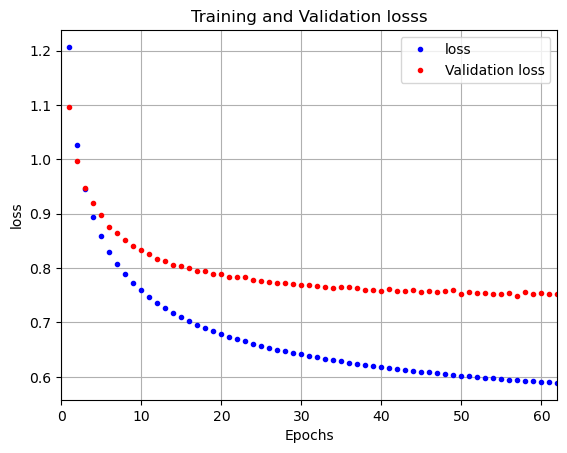

In [16]:
plot_training_history(history_slp, monitor='loss')

 ## Scaling up: developing a model that overfits

In [17]:
mlp = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

mlp_initial_weights = mlp.get_weights()

mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 320,324
Trainable params: 320,324
Non-trainable params: 0
_________________________________________________________________


In [18]:
learning_rate = 0.0025

mlp.compile(optimizer=RMSprop(learning_rate=learning_rate), 
            loss=LOSS_FUNC, metrics=METRICS)

mlp.set_weights(mlp_initial_weights)

In [19]:
EPOCHS = 100
batch_size=512

mlp.set_weights(mlp_initial_weights)

history_mlp = mlp.fit(X_train, y_train,
                      class_weight=CLASS_WEIGHT,
                      batch_size=batch_size, epochs=EPOCHS, 
                      validation_data=(X_val, y_val),
                      callbacks=[],
                      verbose=0)

2023-03-03 14:48:00.718332: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1183920000 exceeds 10% of free system memory.


In [49]:
scores = mlp.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(scores[0], baseline))
print('Precision (Validation): {:.2f}'.format(scores[1]))
print('Recall (Validation): {:.2f}'.format(scores[2]))
print('AUC (Validation): {:.2f}'.format(scores[3]))

Accuracy (Validation): 0.84 (baseline=0.30)
Precision (Validation): 0.86
Recall (Validation): 0.83
AUC (Validation): 0.96


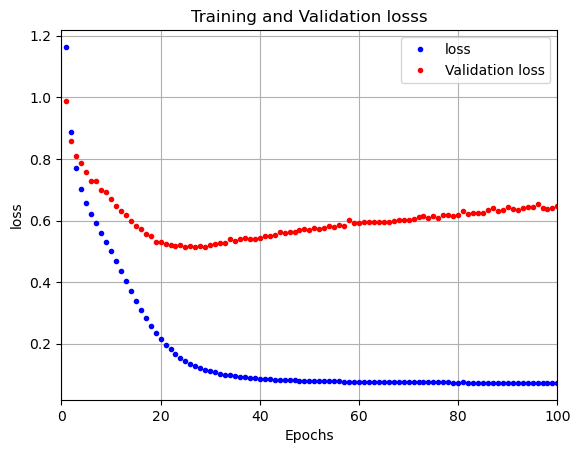

In [21]:
plot_training_history(history_mlp, monitor='loss')

 ## Regularizing your model and tuning your hyperparameters

In [32]:
def cross_validation(X, y,
                     class_weight,
                     ref_arch,
                     dropout_layers,
                     kfolds, params, epochs,
                     callbacks, seed=0) :
    evaluations = []
    for train, validate in kfolds.split(X, y.argmax(axis=1)) :
        model = clone_model(ref_arch)
        
        for j in dropout_layers :
            model.layers[j].rate = params['dropout']
        
        model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']), 
                      loss=LOSS_FUNC, metrics=METRICS)
        
        history = model.fit(X[train,:], y[train,:],
                            class_weight=class_weight,
                            batch_size=params['batch_size'], epochs=epochs, 
                            validation_data=(X[validate,:], y[validate,:]),
                            callbacks=callbacks,
                            verbose=0)
        
        evaluation = model.evaluate(X_val, y_val, verbose=0)[1:]
        evaluations.append( evaluation )
        
    return np.mean(evaluations, axis=0)

In [33]:
def grid_search_cv(X, y,
                   class_weight,
                   model,
                   dropout_layers,
                   search_space, cv,
                   epochs, callbacks=[], seed=0) :
    
    keys, values = zip(*search_space.items())
    
    kfolds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        
        scores = cross_validation(X, y, class_weight,
                                  model, initial_weights, 
                                  dropout_layers,
                                  kfolds, params, epochs,
                                  callbacks, seed)
        
        stats[str(params)] = scores
    
    return stats

In [34]:
# over-sized model - NN architecture that can overfit the data
ref_arch = Sequential(
    [
        Dense(64, activation='relu', input_shape=(INPUT_DIMENSION,)),
        Dropout(rate=0.5), # dropout is what we add in to regularise our shrink our over-sized model
        Dense(OUTPUT_CLASSES, activation='softmax')
    ]
)

ref_arch.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                320064    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 260       
                                                                 
Total params: 320,324
Trainable params: 320,324
Non-trainable params: 0
_________________________________________________________________


In [42]:
# our search space
params = {
    'dropout': [0.25, 0.5],
    'learning_rate': [0.0025, 0.5],
    'batch_size': [256, 512]
}

# which layers are the dropout layer, not how many layers
dropout_layers = [1]

EPOCHS = 500
KFOLDS = 5

In [36]:
stats = grid_search_cv(X_train, y_train,
                       class_weight=CLASS_WEIGHT,
                       model=ref_arch,
                       dropout_layers=dropout_layers,
                       search_space=params, cv=KFOLDS,
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED)

In [37]:
stats

{"{'dropout': 0.25, 'learning_rate': 0.0025, 'batch_size': 256}": array([0.82281082, 0.85931571, 0.79700001, 0.95405879]),
 "{'dropout': 0.25, 'learning_rate': 0.0025, 'batch_size': 512}": array([0.82751352, 0.85971271, 0.80716217, 0.95570025]),
 "{'dropout': 0.25, 'learning_rate': 0.5, 'batch_size': 256}": array([0.4327027 , 0.91596608, 0.18681081, 0.6669637 ]),
 "{'dropout': 0.25, 'learning_rate': 0.5, 'batch_size': 512}": array([0.46283784, 0.91652517, 0.27521622, 0.73366117]),
 "{'dropout': 0.5, 'learning_rate': 0.0025, 'batch_size': 256}": array([0.81324323, 0.86636997, 0.76943245, 0.94935095]),
 "{'dropout': 0.5, 'learning_rate': 0.0025, 'batch_size': 512}": array([0.8185946 , 0.86158662, 0.78686486, 0.95231467]),
 "{'dropout': 0.5, 'learning_rate': 0.5, 'batch_size': 256}": array([0.36927027, 0.93105403, 0.11405405, 0.60565635]),
 "{'dropout': 0.5, 'learning_rate': 0.5, 'batch_size': 512}": array([0.40481082, 0.91665508, 0.15602703, 0.64540557])}

In [38]:
# let's pick the setting that is giving us the AUC which is the 2nd one.
# dropout = 0.25
# learning_rate = 0.0025
# batch_size = 512

In [41]:
# optimal parameters are taken out from our k-fold grid-search stats
opt_params = {
    'dropout': 0.25,
    'learning_rate': 0.0025,
    'batch_size': 512
}

opt_mdl = clone_model(ref_arch)

for j in dropout_layers :
    opt_mdl.layers[j] = opt_params['dropout']
    
opt_mdl.compile(optimizer=RMSprop(learning_rate=opt_params['learning_rate']), 
                loss=LOSS_FUNC, metrics=METRICS)
        
history_opt = opt_mdl.fit(X_train, y_train,
                          class_weight=CLASS_WEIGHT,
                          batch_size=opt_params['batch_size'], epochs=EPOCHS, 
                          validation_data=(X_val, y_val),
                          callbacks=[EARLY_STOP],
                          verbose=0)

2023-03-03 16:18:19.963843: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1183920000 exceeds 10% of free system memory.


In [50]:
scores = opt_mdl.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(scores[0], baseline))
print('Precision (Validation): {:.2f}'.format(scores[1]))
print('Recall (Validation): {:.2f}'.format(scores[2]))
print('AUC (Validation): {:.2f}'.format(scores[3]))

Accuracy (Validation): 0.84 (baseline=0.30)
Precision (Validation): 0.88
Recall (Validation): 0.81
AUC (Validation): 0.96


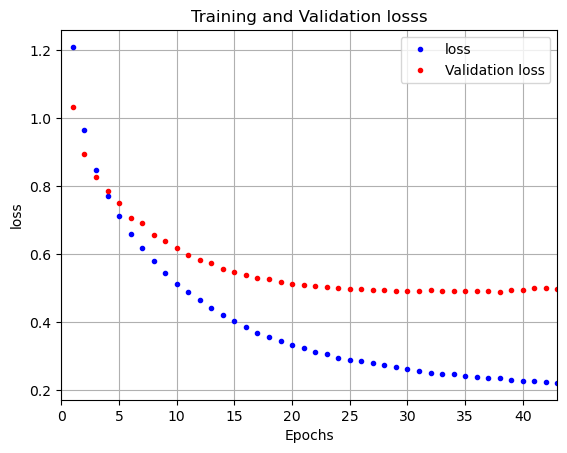

In [45]:
plot_training_history(history_opt, monitor='loss')

In [51]:
scores = opt_mdl.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(scores[0], baseline))
print('Precision (Test): {:.2f}'.format(scores[1]))
print('Recall (Test): {:.2f}'.format(scores[2]))
print('AUC (Test): {:.2f}'.format(scores[3]))

Accuracy (Test): 0.84 (baseline=0.30)
Precision (Test): 0.88
Recall (Test): 0.80
AUC (Test): 0.96


In [47]:
opt_mdl.layers[1]